In [ ]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=2109be013cacbe4eea83e521c184eead0eae3e04e4f062c1769fec90f7e5c99a
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=ffec10fb9cc0b2cc4370964e2b1fe5528919e3eee7b864b1879e52b51f082639
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [ ]:
import torch

import torch.optim as optim
from itertools import chain

from torch.utils.data import DataLoader, TensorDataset, Dataset

from torchsummary import summary
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import random

random.seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import torchvision.datasets
import torchvision.transforms as tr

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, 3, padding=1)
        self.conv2 = torch.nn.Conv2d(10, 30, 3, padding=1)
        self.conv3 = torch.nn.Conv2d(30, latent_size, 3, padding=1)
        self.pool = torch.nn.MaxPool2d(3, 3) 
        self.relu = torch.nn.ReLU()
        self.fc_mu = torch.nn.Linear(latent_size, latent_size) #формирование вектора мат ожиданий
        self.fc_log_var = torch.nn.Linear(latent_size, latent_size) #формирование вектора логарифма дисперсий
        self.latent_size = latent_size

    def forward(self, x):
      x = self.conv1(x)
      x = self.relu(x)
      x = self.pool(x)
      x = self.conv2(x)
      x = self.relu(x)
      x = self.pool(x)
      x = self.conv3(x)
      x = self.relu(x)
      x = self.pool(x)
      x = x.reshape(-1, self.latent_size) #делаем reshape, чтобы в полносвязку передать вектора
      mu = self.fc_mu(x)
      log_var = self.fc_log_var(x)
      return mu, log_var #результат кодера -- это вектор средних и вектор дисперсий

    def sample_latent(self, x): #получаем вектор скрытого состояния Z
        mu, log_var = self.forward(x) #получае вектора средних и дисперсий
        #torch.randn_like(input) Возвращает тензор того же размера, 
        #что и input который заполнен случайными числами из стандартного нормального распределения
        N = torch.randn_like(mu).to(device)

        #дисперсия у нас возвращается в логарифме, а умножить нам надо на стандартное отклонение
        #тогда нужно /2, степень уходит и взять экспоненту, получим просто стандартное отклонение
        return torch.exp(log_var/2) * N + mu, mu, log_var

In [ ]:
import torch.nn.functional as F
class Decoder(torch.nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(latent_size, 30, 3, padding=3)
        self.bn1 = torch.nn.BatchNorm2d(30)
        self.conv2 = torch.nn.Conv2d(30, 10, 3, padding=2)
        self.bn2 = torch.nn.BatchNorm2d(10)
        self.conv3 = torch.nn.Conv2d(10, 1, 3, padding=1)
        self.relu = torch.nn.ReLU()
        self.ups = torch.nn.UpsamplingNearest2d(scale_factor=2)
        self.latent_size = latent_size


    def forward(self, x):
      x = x.view(x.shape[0], 75, 1, 1)
      x = self.ups(x)
      x = self.conv1(x)
      ч = self.bn1(x)
      x = self.relu(x)
      x = self.ups(x)
      x = self.conv2(x)
      x = self.bn2(x)
      x = self.relu(x)
      x = self.ups(x)
      x = self.conv3(x)
      x = self.relu(x)
      return x


In [ ]:
def train_ae(data_loader, encoder, decoder, epochs, lr, device):
    print('Обучение автокодировщика..')

    encoder.train()
    decoder.train()

    recon_loss_func = torch.nn.MSELoss()

    kl_loss_func = lambda mu, log_var: -0.5 * ((1 + log_var -  torch.exp(log_var) - mu**2).sum(dim=1)).mean(dim=0)
    opt = optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=lr)
    loss_history = list()
    loss=0
    for epoch in range(epochs):
        for i, (batch, _) in enumerate(data_loader):
            opt.zero_grad()
            batch = batch.to(device)
            latent_vector, mu, log_sigma = encoder.sample_latent(batch) 
            #получение ошибки MSE
            recon_loss = recon_loss_func(decoder(latent_vector), batch)
            #получение ошибки KL
            kl_loss = kl_loss_func(mu, log_sigma)
            loss = kl_loss + 1000 * recon_loss
            loss.backward()
            opt.step()
            loss_history.append(loss.log().item())
            if i % 100 == 0:
                print('Потери восстановления:', recon_loss.item())
                print('Потери расхождения распределений:', kl_loss.item())
            loss_history.append(loss.log().item())
        print(f'Эпоха {epoch + 1} / {epochs}. Потери на последнем пакете: {loss.item()}')
    encoder.eval()
    decoder.eval()
    print('Готово!')
    plt.plot(loss_history)
    plt.show()

In [ ]:
LATENT_SIZE = 75  # размерность скрытого пространства, можно варьировать.

BATCH_SIZE = 500 # можно варьировать.
EPOCHS = 30 # можно варьировать.
LEARNING_RATE = 0.001 # можно варьировать.

device = 'cuda' if torch.cuda.is_available() else 'cpu'

encoder = Encoder(LATENT_SIZE).to(device)
decoder = Decoder(LATENT_SIZE).to(device)

In [ ]:
data = torchvision.datasets.MNIST('./', download = True, train = True, transform = tr.ToTensor())
train_data_loader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 49034032.80it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 13376291.28it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 58855644.79it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 23842964.67it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Обучение автокодировщика..
Потери восстановления: 0.16498243808746338
Потери расхождения распределений: 0.4787684679031372
Потери восстановления: 0.06913716346025467
Потери расхождения распределений: 1.4310979843139648
Эпоха 1 / 30. Потери на последнем пакете: 67.17837524414062
Потери восстановления: 0.06556860357522964
Потери расхождения распределений: 1.4937915802001953
Потери восстановления: 0.056551333516836166
Потери расхождения распределений: 4.455346584320068
Эпоха 2 / 30. Потери на последнем пакете: 59.534210205078125
Потери восстановления: 0.05370410904288292
Потери расхождения распределений: 5.035889625549316
Потери восстановления: 0.04842286556959152
Потери расхождения распределений: 7.1594929695129395
Эпоха 3 / 30. Потери на последнем пакете: 54.28175354003906
Потери восстановления: 0.04768291488289833
Потери расхождения распределений: 7.121402740478516
Потери восстановления: 0.04294275864958763
Потери расхождения распределений: 8.465165138244629
Эпоха 4 / 30. Потери на пос

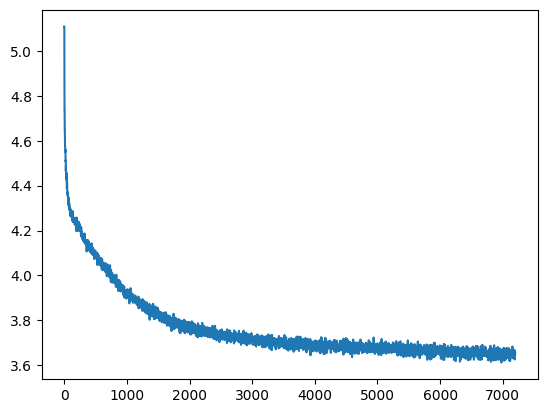

In [ ]:
train_ae(train_data_loader, encoder, decoder, EPOCHS, LEARNING_RATE, device)

In [ ]:
MNIST_test=torchvision.datasets.MNIST('./', download = True, train = False)

In [ ]:
X_test = MNIST_test.train_data/255

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [ ]:
X_test = X_test.unsqueeze(1).to(device)

In [ ]:
X_test.shape

torch.Size([10000, 1, 28, 28])

In [ ]:
Z = encoder.sample_latent(X_test)[0] #скрытое пространство

In [ ]:
Z.shape

torch.Size([10000, 75])

In [ ]:
import umap
import seaborn as sns

In [ ]:
result = pd.DataFrame(Z.detach().cpu().numpy())

In [ ]:
result.head(5) #получили 10000 объектов в скрытом состоянии

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,2.598127,-0.704896,0.932456,0.081722,0.186305,-0.414167,-0.842456,-0.457209,-0.150102,-0.596843,...,0.502014,-0.237414,0.235963,-1.346933,-1.912042,0.450409,-1.583846,-0.165033,0.453542,-0.662519
1,1.267629,-0.798360,0.288558,-0.052039,-0.609959,-0.176986,0.384543,1.343045,-0.677455,0.726827,...,-1.468320,-0.101027,0.265699,-0.025567,0.810494,-0.885964,-0.514503,-0.748925,-0.446764,-0.161661
2,1.025564,0.694005,-0.597703,1.521956,0.154638,1.543060,-1.175354,-1.272723,0.584681,-0.811743,...,-0.961587,1.542239,0.943335,-0.206150,1.509993,0.661209,-1.378080,0.722309,-0.048486,0.994608
3,0.221330,0.443017,1.366679,-1.828496,-0.621844,-0.618150,0.083066,0.347280,0.051248,1.341280,...,1.367183,0.312666,-0.447945,-0.759273,-1.284904,0.030999,0.562566,-0.728880,-0.416865,0.080812
4,-1.054002,-0.927482,-0.767363,0.049034,-1.279451,-2.309998,0.198263,1.363509,0.561794,1.294732,...,-1.662202,0.427801,-0.775478,-0.030282,0.307652,-0.885420,0.259914,-0.714768,1.870663,0.581812


In [ ]:
a = umap.UMAP(random_state=123).fit_transform(result)

In [ ]:
MNIST_test.test_labels

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


tensor([7, 2, 1,  ..., 4, 5, 6])

In [ ]:
d = {'col1': a[:,0], 'col2': a[:,1]}
a = pd.DataFrame(data=d)
a['label'] = MNIST_test.test_labels

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [ ]:
print(a)

          col1      col2  label
0     8.531103  6.242733      7
1     5.107310  7.417596      2
2     7.450937  6.544919      1
3     4.963858  5.574514      0
4     6.981983  3.297610      4
...        ...       ...    ...
9995  5.576414  7.306834      2
9996  6.697110  5.116829      3
9997  6.685011  5.270939      4
9998  8.113566  6.170975      5
9999  5.129750  5.361317      6

[10000 rows x 3 columns]


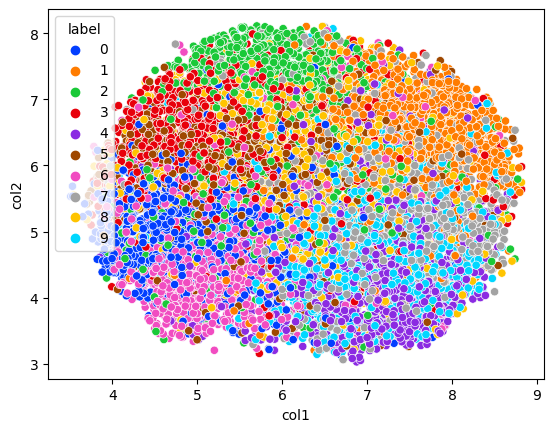

In [ ]:
fig = plt.figure()
sns.scatterplot(x='col1',y='col2',data=a, palette='bright', hue=a['label'])
plt.show()

In [ ]:
means = result.mean(axis=0)
vars = result.std(axis=0)**2

(array([ 1.,  0.,  2.,  0., 40., 28.,  2.,  1.,  0.,  1.]),
 array([-0.29918867, -0.23898676, -0.17878485, -0.11858293, -0.05838102,
         0.00182089,  0.06202281,  0.12222472,  0.18242663,  0.24262854,
         0.30283046]),
 <BarContainer object of 10 artists>)

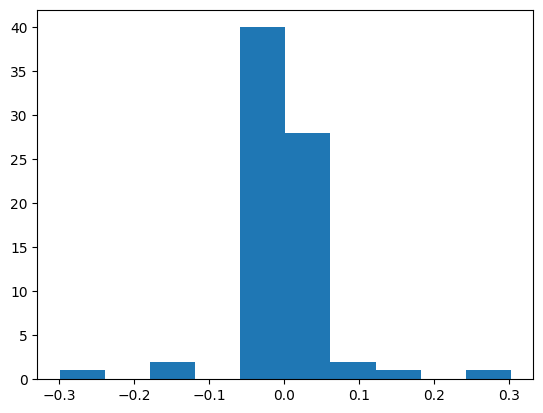

In [ ]:
plt.hist(means)

(array([ 1.,  2., 13., 29., 23.,  4.,  1.,  1.,  0.,  1.]),
 array([0.90551198, 0.9286359 , 0.95175982, 0.97488374, 0.99800766,
        1.02113152, 1.0442555 , 1.06737947, 1.09050333, 1.1136272 ,
        1.13675117]),
 <BarContainer object of 10 artists>)

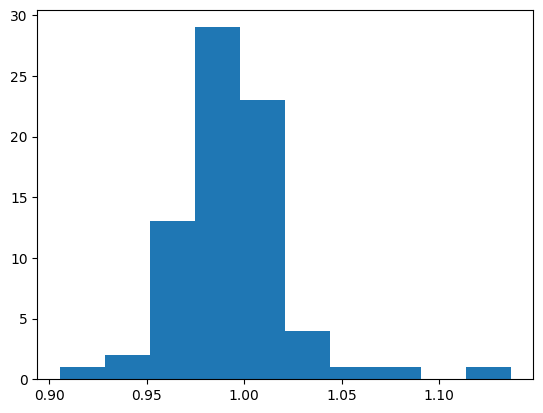

In [ ]:
plt.hist(vars)

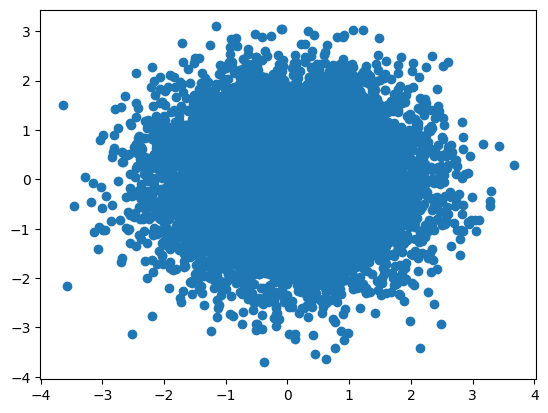

In [ ]:
plt.scatter(result.iloc[:,0],result.iloc[:,1])

In [ ]:
restored_imgs = decoder(Z[:5])

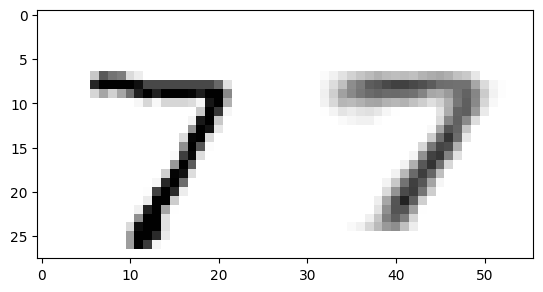

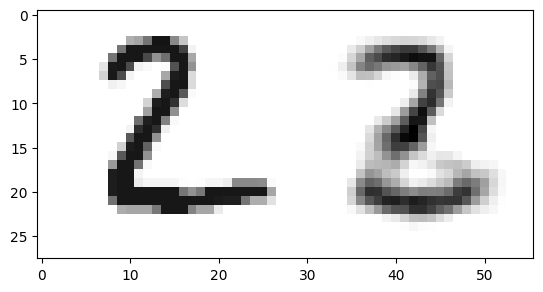

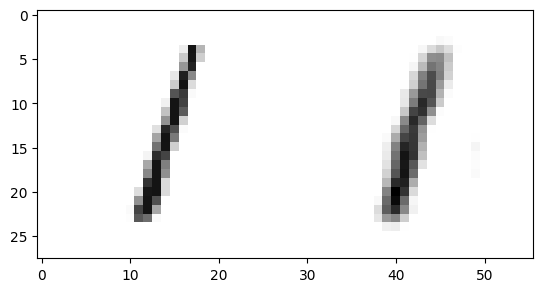

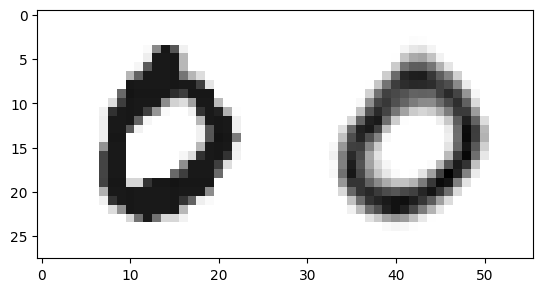

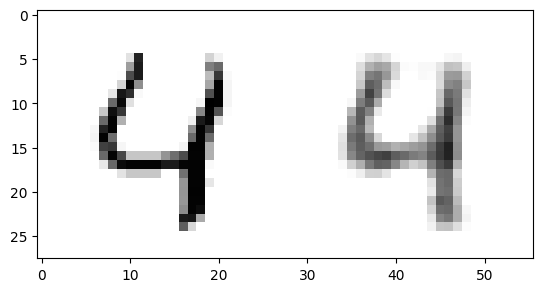

In [ ]:
for i in range(restored_imgs.shape[0]):
  orig_restored = torch.hstack((X_test[i][0], restored_imgs[i][0].detach()))
  plt.imshow(orig_restored.cpu().numpy(), cmap='Greys')
  plt.show()

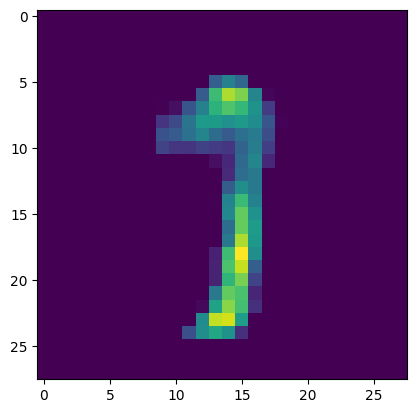

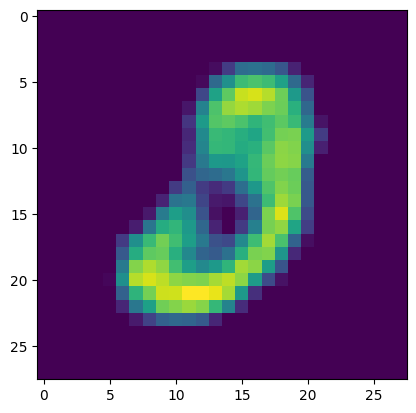

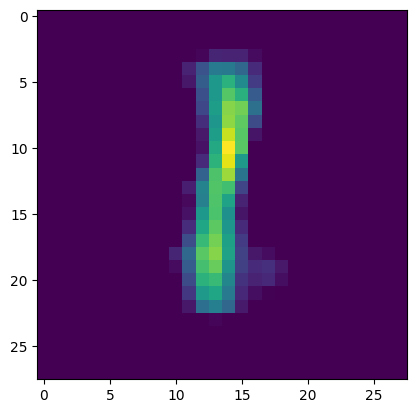

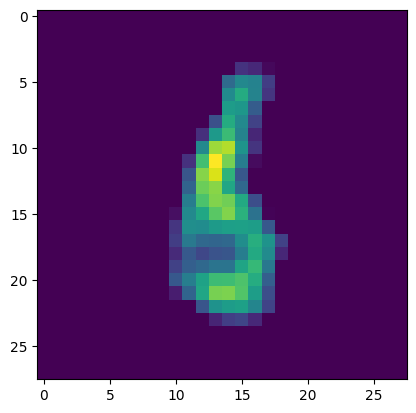

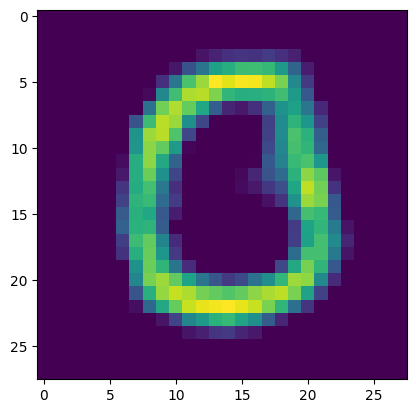

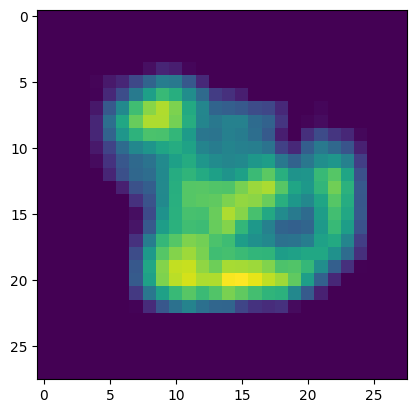

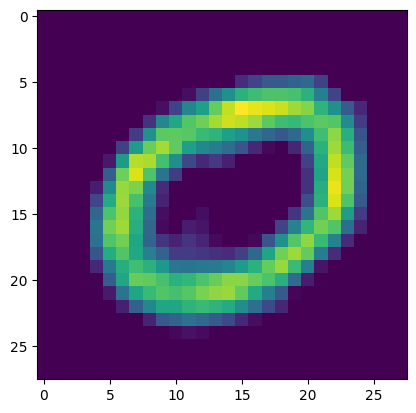

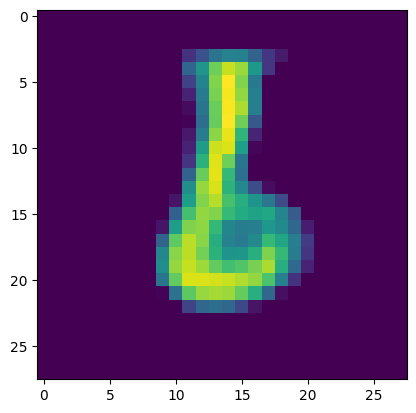

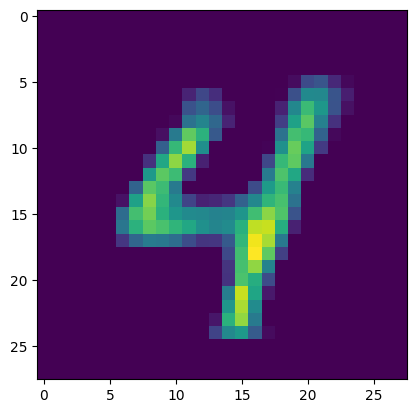

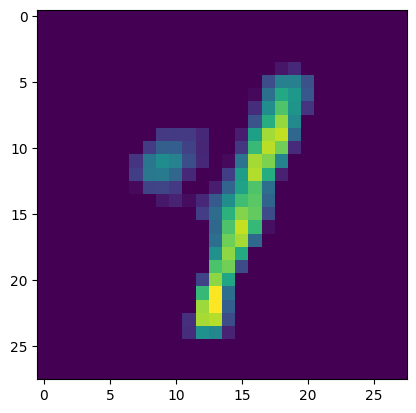

In [ ]:
for _ in range(10):
    gen_latent = torch.randn(123, LATENT_SIZE, device=device)
    gen_digit = decoder(gen_latent).cpu()
    plt.imshow(gen_digit.detach()[0][0].numpy())
    plt.show()